In [2]:
import csv
import datetime
import logging
from dateutil import rrule
import time

from pkg_resources import resource_filename

from nupic.frameworks.opf.model_factory import ModelFactory

import anomaly_model_params

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.animation as animation

from IPython.display import HTML

<IPython.core.display.Javascript object>


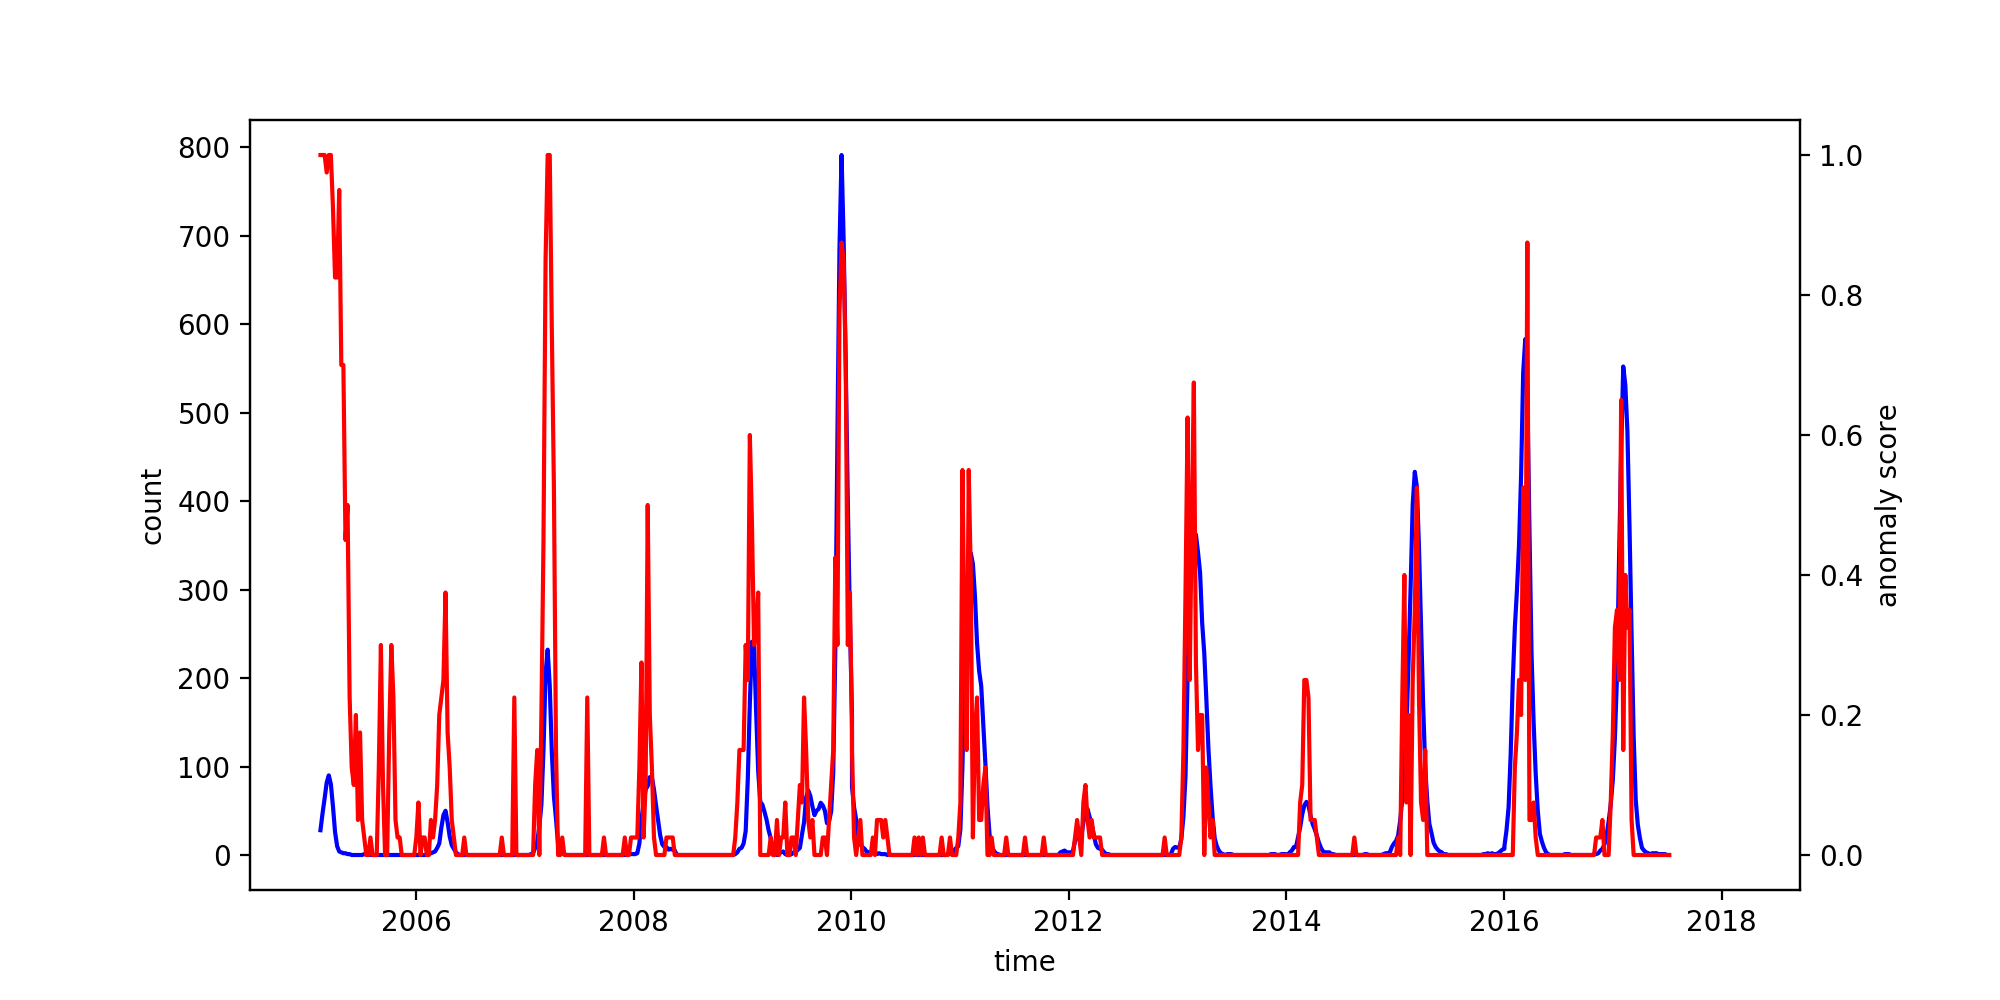

In [31]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()

data = pd.read_csv("anomaly_scores.csv")
data.timestamp = pd.to_datetime(data.timestamp)
    
line, = ax.plot(data.timestamp, data["count"], c='b')
ax.set_xlabel('time')
ax.set_ylabel('count')

line2, = ax2.plot(data.timestamp, data.anomaly_score, c='r')
ax2.set_ylabel('anomaly score')

def update(num, ts):
    line.set_data(data.iloc[:num,:].timestamp.values, data.iloc[:num,:]['count'].values)
    line2.set_data(data.iloc[:num,:].timestamp.values, data.iloc[:num,:].anomaly_score.values)
    
    return [line, line2]

ani = animation.FuncAnimation(fig, update, data.shape[0], interval=2, blit=True, fargs=[data.timestamp])
plt.show()

('Anomaly scores have been written to', 'anomaly_scores.csv')


INFO:__main__:Anomaly detected at [2005-02-13 00:00:00]. Anomaly score: 1.000000.
INFO:__main__:Anomaly detected at [2005-09-04 00:00:00]. Anomaly score: 0.300000.
INFO:__main__:Anomaly detected at [2006-03-19 00:00:00]. Anomaly score: 0.200000.
INFO:__main__:Anomaly detected at [2006-11-26 00:00:00]. Anomaly score: 0.225000.
INFO:__main__:Anomaly detected at [2007-02-25 00:00:00]. Anomaly score: 0.200000.
INFO:__main__:Anomaly detected at [2007-07-29 00:00:00]. Anomaly score: 0.225000.
INFO:__main__:Anomaly detected at [2008-01-27 00:00:00]. Anomaly score: 0.275000.
INFO:__main__:Anomaly detected at [2009-01-11 00:00:00]. Anomaly score: 0.300000.
INFO:__main__:Anomaly detected at [2009-07-26 00:00:00]. Anomaly score: 0.225000.
INFO:__main__:Anomaly detected at [2009-11-08 00:00:00]. Anomaly score: 0.425000.
INFO:__main__:Anomaly detected at [2011-01-09 00:00:00]. Anomaly score: 0.550000.
INFO:__main__:Anomaly detected at [2013-01-27 00:00:00]. Anomaly score: 0.375000.
INFO:__main__:An

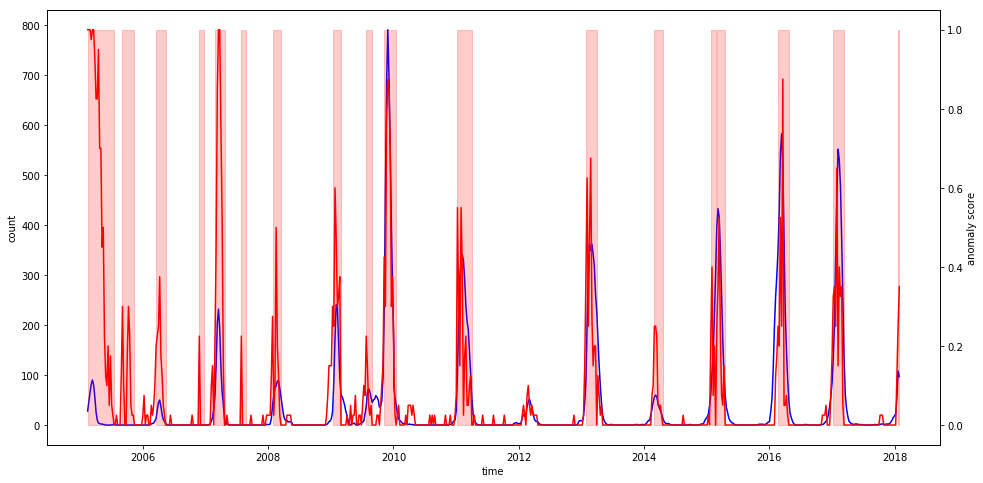

In [3]:
# anomaly stuff

_LOGGER = logging.getLogger(__name__)

_INPUT_FILE_PATH = '../data/smoothed.csv'

_OUTPUT_PATH = "anomaly_scores.csv"

_ANOMALY_THRESHOLD = 0.2

_EARLIEST = datetime.datetime(2001, 1, 1)

def createModel():
    return ModelFactory.create(anomaly_model_params.MODEL_PARAMS)


def runHotgymAnomaly():
    model = createModel()
    model.enableInference({'predictedField': 'count'})
    block = False
    count = 0
    anomalies = []
    start = None
    end = None
    with open (_INPUT_FILE_PATH) as fin:
        reader = csv.reader(fin)
        csvWriter = csv.writer(open(_OUTPUT_PATH,"wb"))
        csvWriter.writerow(["timestamp", "count", "anomaly_score"])
        headers = reader.next()
        reader.next()
        reader.next()
        for i, record in enumerate(reader, start=1):
            modelInput = dict(zip(headers, record))
            modelInput["count"] = float(modelInput["count"])
            modelInput["Influenza"] = float(modelInput["Influenza"])
            modelInput["timestamp"] = datetime.datetime.strptime(modelInput["timestamp"], "%Y-%m-%d")
            result = model.run(modelInput)
            anomalyScore = result.inferences['anomalyScore']
            csvWriter.writerow([modelInput["timestamp"], int(modelInput["count"]),
                                anomalyScore])
            if anomalyScore > _ANOMALY_THRESHOLD:
                if not block:
                    block = True
                    count += 1
                    start = result.rawInput['timestamp']
                    _LOGGER.info("Anomaly detected at [%s]. Anomaly score: %f.",
                                 result.rawInput["timestamp"], anomalyScore)
                else:
                    count += 1
            elif count > 0:
                count += 1
            if (count >= 5) and (anomalyScore < 0.02):
                count = 0
                block = False
                end = result.rawInput['timestamp']
                anomalies.append((start, end))
        # also get outbreak at end of data
        end = result.rawInput['timestamp']
        anomalies.append((start, end))
    return anomalies

print("Anomaly scores have been written to",_OUTPUT_PATH)

def weeks_between(start_date, end_date):
    weeks = rrule.rrule(rrule.WEEKLY, dtstart=start_date, until=end_date)
    return weeks.count()

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    anomalies = runHotgymAnomaly()

    # load data
    data = pd.read_csv("anomaly_scores.csv")
    data.timestamp = pd.to_datetime(data.timestamp)
    data = data.loc[data.timestamp > _EARLIEST]
    data.head()

    # In[10]:

    fig, ax = plt.subplots(figsize=(16, 8))
    ax2 = ax.twinx()

    # plot count in blue
    ax.plot(data.timestamp, data["count"], c='b')
    ax.set_xlabel('time')
    ax.set_ylabel('count')

    # plot anomaly score in red
    ax2.plot(data.timestamp, data.anomaly_score, c='r')
    ax2.set_ylabel('anomaly score')

    # plot anomalies
    for (startTime, endTime) in anomalies:
        if startTime <= _EARLIEST:
            continue
        # convert to matplotlib date representation
        start = mdates.date2num(startTime)
        end = mdates.date2num(endTime)
        width = end - start

        # Plot rectangle
        rect = patches.Rectangle((start, 0), width, 1, color='red', alpha=0.2)
        ax2.add_patch(rect)


    plt.show()